In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms

import torch
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F

In [3]:

class Classifier(nn.Module): 
    def __init__(self, classes: int = 10): 
        super().__init__() 
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1) 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) 
        self.pool = nn.MaxPool2d(2, 2) 
        #self.dropout1 = nn.Dropout2d(0.25) 
        #self.dropout2 = nn.Dropout2d(0.5) 
        self.fc1 = nn.Linear(64 * 7 * 7, 128) 
        self.fc2 = nn.Linear(128, classes) 
  
    def forward(self, x): 
        x = self.pool(F.relu(self.conv1(x))) 
        #x = self.dropout1(x) 
        x = self.pool(F.relu(self.conv2(x))) 
        #x = self.dropout2(x) 
        x = x.view(-1, 64 * 7 * 7) 
        x = F.relu(self.fc1(x)) 
        x = self.fc2(x) 
        return x

In [4]:
# imports for model changes
from src.methods.bayes.variational.net import NormalVarBayesModule

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
test_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
train_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

### Define parameters for training

In [7]:
from typing import Dict
# imports for model changes
from src.methods.bayes.variational.net import VarBayesModuleNet
from src.methods.bayes.variational.net import NormalVarBayesModule
from src.methods.bayes.variational.optimization import VarRenuiLoss, VarDistLoss

# imports for trainer
from src.methods.bayes.variational.trainer import VarBayesTrainer, VarTrainerParams, Beta_Scheduler_Plato, CallbackLossAccuracy
from src.methods.report.base import ReportChain
from src.methods.report.variational import VarBaseReport

In [8]:

def fit(self, dataset: torch.utils.data.Dataset,
        trainer_params: Dict[str, any] = {
                "num_epochs": 1,
                "beta": 1e-2,
                "prune_threshold": -5,
                "num_samples": 5
            },
        dataloader_params: Dict[str, any] = {
                "val_ratio": 0.2,
                "batch_size": 128
            },
        callback_losses: Dict[str, nn.Module] = {
                'accuracy': CallbackLossAccuracy()
            },
        optimizer_cls=torch.optim.Adam,
        optimizer_params: Dict[str, any] = {
                "lr": 1e-3
            },
        fit_loss=nn.CrossEntropyLoss(reduction="sum"),
        distribution_loss: VarDistLoss = VarRenuiLoss(),
        report_chain=ReportChain([VarBaseReport()])
        ):

    # model = self
    optimizer = optimizer_cls(self.parameters(), **optimizer_params)

    # prepare dataloaders from data
    val_size = int(dataloader_params["val_ratio"] * len(dataset))
    train_size = len(dataset) - val_size
    batch_size = dataloader_params['batch_size']
    t_dataset, v_dataset = torch.utils.data.random_split(dataset, \
                                                    [train_size, val_size])

    # Create DataLoaders for the training and validation sets
    train_loader = torch.utils.data.DataLoader(t_dataset,
                                            batch_size=batch_size,
                                            shuffle=True,
                                            pin_memory=True)

    eval_loader = torch.utils.data.DataLoader(v_dataset,
                                            batch_size=batch_size,
                                            shuffle=False,
                                            pin_memory=True)

    train_params = VarTrainerParams(
            optimizer=optimizer,
            fit_loss=fit_loss,
            dist_loss=distribution_loss,
            callback_losses=callback_losses,
            **trainer_params
            )

    trainer = VarBayesTrainer(train_params, report_chain, train_loader, eval_loader)
    trainer.train(self)
    return self, trainer

In [9]:
base_module = Classifier()

model = NormalVarBayesModule.from_module(base_module)

ReportChain([VarBaseReport()])

model, trainer = fit(model, train_dataset)

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1/1],Loss:2128.74609375, KL Loss: 185506.421875. FitLoss: 288.91693115234375,Accuracy:0.17065972222222223,Validation Loss:1988.19091796875,Validation Accuracy:0.6, Prune parameters: 610.0/421642,Beta: 0.01


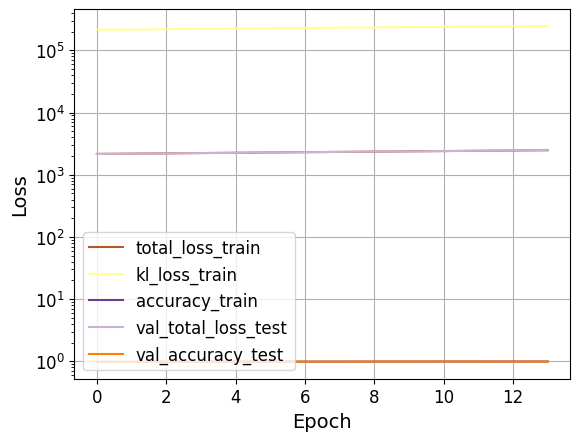

KeyboardInterrupt: 

In [22]:
from src.methods.report.base import ReportChain
from src.methods.report.visualise import VarPlotReport

report_chain = ReportChain([VarPlotReport(report_names=['total_loss', 'kl_loss', "accuracy"], 
                                        val_report_names=['val_total_loss', "val_accuracy"], 
                                        logscale_y=True)])
trainer_params = { "num_epochs": 30,"beta": 0.01,"prune_threshold": -5, "num_samples": 4}
dataloader_params = { "val_ratio": 0.2,"batch_size": 512 }

model.to(device)
model, trainer = fit(model,test_dataset, 
                     trainer_params=trainer_params,
                     dataloader_params = dataloader_params, 
                     report_chain=report_chain)

### Show, that  trained model can be pruned well

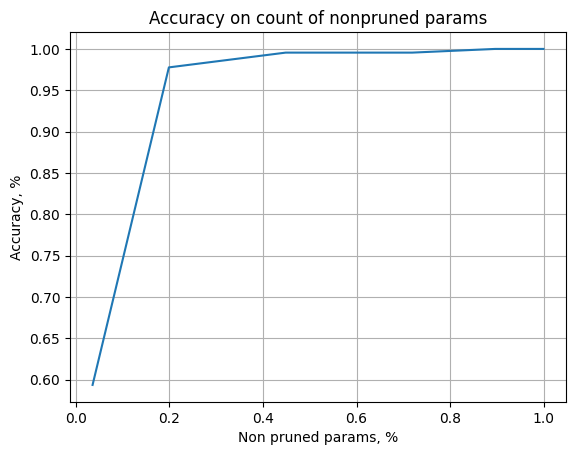

In [23]:
thresholds = np.linspace(-5, 5, 10)
threshold_results = trainer.eval_thresholds(model, thresholds)

# plot dependence of accuracy on count on non pruned parameter
x_s = [(a.cnt_prune_parameters / a.cnt_params).cpu().numpy() for a in threshold_results]
x_s = 1. - np.array(x_s) # now we get partition of non pruned parameters
y_s = [a.custom_losses["val_accuracy"] for a in threshold_results]

plt.plot(x_s, y_s)
plt.xlabel("Non pruned params, %")
plt.ylabel("Accuracy, %")
plt.title("Accuracy on count of nonpruned params")
plt.grid()

In [ ]:

def fit(self, dataset: torch.utils.data.Dataset,
        trainer_params: Dict[str, any] = {
                "num_epochs": 1,
                "beta": 1e-2,
                "prune_threshold": -5,
                "num_samples": 5
            },
        dataloader_params: Dict[str, any] = {
                "val_ratio": 0.2,
                "batch_size": 128
            },
        callback_losses: Dict[str, nn.Module] = {
                'accuracy': CallbackLossAccuracy()
            },
        optimizer_cls=torch.optim.Adam,
        optimizer_params: Dict[str, any] = {
                "lr": 1e-3
            },
        fit_loss=nn.CrossEntropyLoss(reduction="sum"),
        distribution_loss: VarDistLoss = VarRenuiLoss(),
        report_chain=ReportChain([VarBaseReport()])
        ):

    # model = self
    optimizer = optimizer_cls(self.parameters(), **optimizer_params)

    # prepare dataloaders from data
    val_size = int(dataloader_params["val_ratio"] * len(dataset))
    train_size = len(dataset) - val_size
    batch_size = dataloader_params['batch_size']
    t_dataset, v_dataset = torch.utils.data.random_split(dataset, \
                                                    [train_size, val_size])

    # Create DataLoaders for the training and validation sets
    train_loader = torch.utils.data.DataLoader(t_dataset,
                                            batch_size=batch_size,
                                            shuffle=True,
                                            pin_memory=True)

    eval_loader = torch.utils.data.DataLoader(v_dataset,
                                            batch_size=batch_size,
                                            shuffle=False,
                                            pin_memory=True)

    train_params = VarTrainerParams(
            optimizer=optimizer,
            fit_loss=fit_loss,
            dist_loss=distribution_loss,
            callback_losses=callback_losses,
            **trainer_params
            )

    trainer = VarBayesTrainer(train_params, report_chain, train_loader, eval_loader)
    trainer.train(self)
    return self, trainer